In [1]:
import gluonts
gluonts.__version__

'0.4.2'

In [2]:
import mxnet
mxnet.__version__

'1.4.1'

In [3]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [4]:
dataname = "m4_daily"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_daily


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/test/data.json


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [6]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [7]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='D'),
 'target': array([1017.1, 1019.3, 1017. , ..., 2022.1, 2031.6, 2029.7], dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json'), line=1), row=1)}

## Plot Series

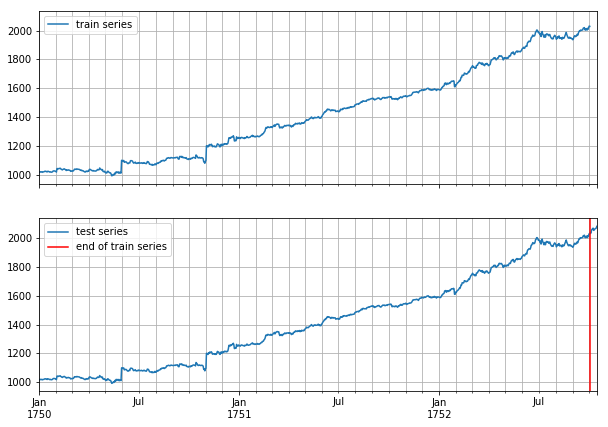

In [8]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [9]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [10]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


## Results

In [15]:
results = pd.DataFrame()

for i in range(47, 52):
    print("Seed:", i)
    df = deepar(data="m4_yearly", seed=i, epochs=500, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 1179723


Seed: 47


100%|██████████| 100/100 [00:01<00:00, 55.30it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[0] Elapsed time 1.810 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.934286
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.41it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 1.657 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.753271
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.19it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[2] Elapsed time 1.955 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.864731
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.40it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 1.807 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.340377
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.77it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[4] Elapsed time 1.703 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 53.31it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[37] Elapsed time 1.877 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.572420
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.94it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[38] Elapsed time 1.965 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.236442
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 50.65it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[39] Elapsed time 1.976 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.447886
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.79it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 1.795 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.940699
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.41it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[41] Elapsed time 1.874 second

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.553703
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 59.60it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[74] Elapsed time 1.680 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.221798
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 60.10it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[75] Elapsed time 1.666 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.526304
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 61.20it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 1.636 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.852852
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 56.58it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[77] Elapsed time 1.769 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.249399
INFO:root:Epoch[78] Learning rate is 0.00025
100

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.515163
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.04it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[110] Elapsed time 1.961 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.208688
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.30it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[111] Elapsed time 1.810 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.385170
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.78it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[112] Elapsed time 1.862 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.936927
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.33it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[113] Elapsed time 1.716 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.292053
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 58.17it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[146] Elapsed time 1.721 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.235825
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.45it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[147] Elapsed time 1.713 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.584905
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.05it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[148] Elapsed time 1.695 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.739064
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.88it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[149] Elapsed time 1.700 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.250362
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.83it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.33it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[183] Elapsed time 1.877 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.681634
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.29it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[184] Elapsed time 1.778 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.459986
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.03it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[185] Elapsed time 1.755 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.284298
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.98it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[186] Elapsed time 1.669 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.394344
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.56it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.654915
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.14it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[220] Elapsed time 1.783 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.560660
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.81it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[221] Elapsed time 1.896 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.267189
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.29it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[222] Elapsed time 1.810 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.348856
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.57it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[223] Elapsed time 1.739 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.261721
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 54.98it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[256] Elapsed time 1.821 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.471271
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.81it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[257] Elapsed time 1.932 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.269953
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.84it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[258] Elapsed time 1.859 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.367779
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[259] Elapsed time 1.862 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.239103
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.33it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[260] Elapsed time 

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.67it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[293] Elapsed time 1.798 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.239504
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.98it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[294] Elapsed time 1.757 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.312457
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.54it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[295] Elapsed time 1.836 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.285204
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.20it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[296] Elapsed time 1.635 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.450709
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.27it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.253560
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.45it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[330] Elapsed time 1.873 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.317608
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.94it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[331] Elapsed time 1.822 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.213733
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.43it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[332] Elapsed time 1.774 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.437576
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.40it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[333] Elapsed time 1.986 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.163268
INFO:root:Epoch[334] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 56.07it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[366] Elapsed time 1.787 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.263985
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.97it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[367] Elapsed time 1.669 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.049401
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.96it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[368] Elapsed time 1.644 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.474349
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.91it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[369] Elapsed time 1.892 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.176752
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.06it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[370] Elapsed time

INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.33it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[403] Elapsed time 1.950 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.009670
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.74it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[404] Elapsed time 1.863 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.470547
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.84it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[405] Elapsed time 1.969 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.222173
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.07it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[406] Elapsed time 1.786 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.613878
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.942291
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.98it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[440] Elapsed time 2.003 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.556529
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.09it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[441] Elapsed time 2.039 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.207603
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.78it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[442] Elapsed time 1.732 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.698013
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.09it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[443] Elapsed time 1.694 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.269998
INFO:root:Epoch[444] Learning rate is 5e-05


100%|██████████| 100/100 [00:02<00:00, 49.28it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[476] Elapsed time 2.031 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.696014
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.20it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[477] Elapsed time 1.917 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.278313
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.96it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[478] Elapsed time 1.642 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.640544
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.77it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[479] Elapsed time 1.675 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.213680
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.83it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[480] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.242737  0.139396  46.541989            0.135162            0.079709   

   seed  epochs  num_batches  
0    47     500          100  
Seed: 48


100%|██████████| 100/100 [00:01<00:00, 55.00it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 1.820 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.060506
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.68it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[1] Elapsed time 1.706 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.712753
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.57it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[2] Elapsed time 1.739 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.769746
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.65it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 1.901 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.187852
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.80it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 1.794 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 59.06it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[37] Elapsed time 1.695 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.629172
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.84it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[38] Elapsed time 1.761 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.146801
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.44it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[39] Elapsed time 1.713 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.478011
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.38it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[40] Elapsed time 1.807 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.912363
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 53.51it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 47.96it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[73] Elapsed time 2.087 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.625791
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 51.65it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[74] Elapsed time 1.938 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.282143
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 53.98it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[75] Elapsed time 1.854 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.532384
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 57.70it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[76] Elapsed time 1.735 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.974274
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.48it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.40it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[110] Elapsed time 1.947 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.329908
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.30it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[111] Elapsed time 1.878 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.548922
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.05it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[112] Elapsed time 1.786 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.846419
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.53it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[113] Elapsed time 2.106 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.332214
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.04it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.344511
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.04it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[147] Elapsed time 1.725 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.631698
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.68it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[148] Elapsed time 1.649 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.735198
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.35it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[149] Elapsed time 1.776 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.265725
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.02it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[150] Elapsed time 1.725 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.522724
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 59.25it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[183] Elapsed time 1.690 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.716677
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.15it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[184] Elapsed time 1.637 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.627865
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.87it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[185] Elapsed time 1.700 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.322036
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.95it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[186] Elapsed time 1.670 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.397036
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.46it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[187] Elapsed time 

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.43it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[220] Elapsed time 1.744 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.401574
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.15it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[221] Elapsed time 1.752 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.346754
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.13it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[222] Elapsed time 1.884 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.376035
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.96it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[223] Elapsed time 1.727 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.136499
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.34it/s, avg_epoch_l

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.342792
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.89it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[257] Elapsed time 2.007 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.472450
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.73it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[258] Elapsed time 1.796 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.244504
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.09it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[259] Elapsed time 1.817 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.016919
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 63.50it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[260] Elapsed time 1.576 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=5.645232
INFO:root:Epoch[261] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 53.85it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[293] Elapsed time 1.860 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.468574
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.27it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[294] Elapsed time 1.718 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.191413
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.92it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[295] Elapsed time 1.671 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.888466
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.74it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[296] Elapsed time 1.676 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.704864
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.39it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[297] Elapsed time 

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.57it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[330] Elapsed time 1.681 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.221547
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.94it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[331] Elapsed time 1.643 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.795253
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.27it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[332] Elapsed time 1.779 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.727019
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.05it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[333] Elapsed time 1.819 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.312623
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.97it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.236875
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.70it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[367] Elapsed time 1.679 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.836400
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.70it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[368] Elapsed time 1.832 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.687065
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.29it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[369] Elapsed time 1.914 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.245831
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.16it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[370] Elapsed time 1.848 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.706857
INFO:root:Epoch[371] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 54.80it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[403] Elapsed time 1.826 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.740028
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.26it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[404] Elapsed time 1.879 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.716571
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.86it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[405] Elapsed time 1.859 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.319007
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.75it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[406] Elapsed time 1.764 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.697884
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.55it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[407] Elapsed time 

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.80it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[440] Elapsed time 1.702 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.858719
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.06it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[441] Elapsed time 1.695 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.322003
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 62.91it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[442] Elapsed time 1.591 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.739397
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.07it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[443] Elapsed time 1.695 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.148028
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.10it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.823967
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[477] Elapsed time 1.863 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.273888
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.62it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[478] Elapsed time 1.833 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.724273
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.11it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[479] Elapsed time 1.921 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.110580
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.49it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[480] Elapsed time 1.874 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.401014
INFO:root:Epoch[481] Learning rate is 5e-05


       MASE   sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.192804  0.1379  46.125205            0.134519            0.079689    48   

   epochs  num_batches  
0     500          100  
Seed: 49


100%|██████████| 100/100 [00:01<00:00, 50.06it/s, avg_epoch_loss=8.16]
INFO:root:Epoch[0] Elapsed time 2.000 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.157713
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 51.12it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 1.958 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.835981
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.53it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[2] Elapsed time 1.836 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.881321
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.98it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 1.788 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.229445
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.70it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[4] Elapsed time 1.766 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 57.70it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 1.735 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.583796
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.74it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[38] Elapsed time 1.862 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.311158
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.87it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[39] Elapsed time 1.792 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.631948
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.78it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[40] Elapsed time 1.621 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.896760
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.14it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[41] Elapsed time 1.816 seconds

100%|██████████| 100/100 [00:01<00:00, 56.55it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[73] Elapsed time 1.770 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.561062
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.19it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[74] Elapsed time 1.847 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.247862
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.97it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 1.788 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.554549
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.70it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[76] Elapsed time 1.735 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.875649
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 53.37it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:01<00:00, 57.99it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[109] Elapsed time 1.726 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.589573
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.18it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[110] Elapsed time 1.848 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.281366
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.84it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[111] Elapsed time 1.793 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.548385
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.78it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[112] Elapsed time 1.647 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.888368
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.10it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[113] Elapsed time

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.56it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[146] Elapsed time 1.869 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.303966
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.90it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[147] Elapsed time 1.791 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.621967
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.20it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[148] Elapsed time 1.722 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.707573
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.27it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[149] Elapsed time 1.813 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.265397
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.02it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.361110
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.62it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[183] Elapsed time 1.679 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.566470
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.66it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[184] Elapsed time 1.678 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.678460
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.58it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[185] Elapsed time 1.739 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.272321
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.55it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[186] Elapsed time 1.710 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.359608
INFO:root:Epoch[187] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 57.85it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[219] Elapsed time 1.730 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.609396
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.94it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[220] Elapsed time 1.857 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.533121
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.19it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[221] Elapsed time 1.918 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.255024
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[222] Elapsed time 1.862 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.346493
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.39it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[223] Elapsed time

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.55it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[256] Elapsed time 1.835 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.470139
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.58it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[257] Elapsed time 1.941 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.251782
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.99it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[258] Elapsed time 1.854 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.336860
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.27it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[259] Elapsed time 1.718 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.219980
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.14it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.460866
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.15it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[293] Elapsed time 1.692 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.228442
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[294] Elapsed time 1.862 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.335043
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.77it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[295] Elapsed time 1.897 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.245750
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.49it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[296] Elapsed time 1.837 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.451477
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 58.66it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[329] Elapsed time 1.707 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.255104
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.97it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[330] Elapsed time 1.669 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.323581
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.88it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[331] Elapsed time 1.760 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.224354
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.14it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[332] Elapsed time 1.815 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.406357
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 50.95it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.56it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[366] Elapsed time 1.770 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.247019
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.35it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[367] Elapsed time 1.912 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.115345
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.78it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[368] Elapsed time 1.861 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.432685
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.53it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[369] Elapsed time 1.710 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.133450
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.95it/s, avg_epoch_

INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=6.187660
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.29it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[403] Elapsed time 1.914 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.034565
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.08it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[404] Elapsed time 1.785 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.447308
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.11it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[405] Elapsed time 1.753 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.225429
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.75it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[406] Elapsed time 1.796 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.508026
INFO:root:Epoch[407] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 53.75it/s, avg_epoch_loss=6]
INFO:root:Epoch[439] Elapsed time 1.862 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.996796
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.38it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[440] Elapsed time 1.632 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.448826
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.27it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[441] Elapsed time 1.879 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.182194
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.52it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[442] Elapsed time 1.906 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.521182
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.58it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[443] Elapsed time 1.

INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.27it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[476] Elapsed time 1.779 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.447481
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.30it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[477] Elapsed time 1.843 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.231920
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.28it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[478] Elapsed time 1.748 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.467149
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.98it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[479] Elapsed time 1.788 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.515549
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.82it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.277982  0.140103  47.295318            0.136935            0.077945   

   seed  epochs  num_batches  
0    49     500          100  
Seed: 50


100%|██████████| 100/100 [00:01<00:00, 55.59it/s, avg_epoch_loss=8.32]
INFO:root:Epoch[0] Elapsed time 1.801 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.318555
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.18it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 1.720 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.792942
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.79it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[2] Elapsed time 1.794 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.790533
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.82it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 1.793 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.267183
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 58.58it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[4] Elapsed time 1.709 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 54.20it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[37] Elapsed time 1.847 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.836118
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.26it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[38] Elapsed time 1.881 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.043704
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.21it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[39] Elapsed time 1.883 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.527715
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.94it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 1.822 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.935831
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.07it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:01<00:00, 56.81it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[73] Elapsed time 1.763 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.830641
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.27it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[74] Elapsed time 1.782 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.051816
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.67it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[75] Elapsed time 1.800 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.510447
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 57.43it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[76] Elapsed time 1.745 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.964116
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 56.50it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:01<00:00, 58.63it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[109] Elapsed time 1.708 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.702706
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.02it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[110] Elapsed time 1.696 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.228658
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.83it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[111] Elapsed time 1.793 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.427509
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.11it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[112] Elapsed time 1.693 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.937755
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.68it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[113] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.58it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[146] Elapsed time 1.868 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.246610
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.76it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[147] Elapsed time 1.862 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.472523
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.13it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[148] Elapsed time 1.693 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.925550
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.80it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[149] Elapsed time 1.826 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.275118
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.44it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.281092
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.83it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[183] Elapsed time 1.826 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.584853
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.04it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[184] Elapsed time 1.725 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.773814
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.19it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[185] Elapsed time 1.814 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.247485
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.44it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[186] Elapsed time 1.684 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.506314
INFO:root:Epoch[187] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 57.30it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[219] Elapsed time 1.747 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.638746
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.75it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[220] Elapsed time 1.704 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.637299
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.57it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[221] Elapsed time 1.801 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.293917
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.44it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[222] Elapsed time 1.808 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.403855
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.07it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[223] Elapsed time 

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.08it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[256] Elapsed time 1.666 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.567165
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.36it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[257] Elapsed time 1.686 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.305322
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.59it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[258] Elapsed time 1.680 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.355943
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.56it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[259] Elapsed time 1.681 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.286718
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 61.68it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.421320
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.46it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[293] Elapsed time 1.838 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.343836
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.77it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[294] Elapsed time 1.703 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.344686
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.96it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[295] Elapsed time 1.757 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.147399
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.21it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[296] Elapsed time 1.781 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.520657
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 56.95it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[329] Elapsed time 1.758 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.459394
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.93it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[330] Elapsed time 1.671 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.276660
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.12it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[331] Elapsed time 1.665 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.007124
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.90it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[332] Elapsed time 1.671 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.633001
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.40it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[333] Elapsed time

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.11it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[366] Elapsed time 1.850 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.166036
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.66it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[367] Elapsed time 1.901 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.035714
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.66it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[368] Elapsed time 1.938 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.606692
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.62it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[369] Elapsed time 1.902 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.315430
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.82it/s, avg_epoch_

INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=6.202958
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.06it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[403] Elapsed time 1.922 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=6.043847
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.29it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[404] Elapsed time 1.844 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.581172
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.95it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[405] Elapsed time 1.855 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.273127
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.77it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[406] Elapsed time 1.647 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.668021
INFO:root:Epoch[407] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 54.42it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[439] Elapsed time 1.839 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=6.027458
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.30it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[440] Elapsed time 1.747 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.548130
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.03it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[441] Elapsed time 1.819 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.299212
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.97it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[442] Elapsed time 1.789 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.682448
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.90it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[443] Elapsed time 

INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.56it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[476] Elapsed time 1.770 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.625022
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.26it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[477] Elapsed time 1.880 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.281223
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.09it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[478] Elapsed time 2.039 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.736977
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.63it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[479] Elapsed time 1.833 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.288470
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.49it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.159852  0.13844  43.890754            0.135572            0.079219    50   

   epochs  num_batches  
0     500          100  
Seed: 51


100%|██████████| 100/100 [00:01<00:00, 57.18it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 1.751 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.202351
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 59.89it/s, avg_epoch_loss=7]
INFO:root:Epoch[1] Elapsed time 1.671 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.998224
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.27it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[2] Elapsed time 1.879 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.031282
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.28it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 1.844 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.348075
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.45it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[4] Elapsed time 1.656 seconds
INFO:root:Epoch

100%|██████████| 100/100 [00:01<00:00, 59.77it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[37] Elapsed time 1.675 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.643615
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.81it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[38] Elapsed time 1.732 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.161361
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.38it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[39] Elapsed time 1.841 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.427780
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.07it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[40] Elapsed time 1.667 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.906105
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 52.56it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:01<00:00, 56.35it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[73] Elapsed time 1.776 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.623459
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.40it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[74] Elapsed time 1.841 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.292935
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 54.72it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[75] Elapsed time 1.829 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.583021
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 59.38it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[76] Elapsed time 1.686 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.957044
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 53.18it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[77] Elapsed time 1

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.21it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[110] Elapsed time 1.917 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.369799
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.46it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[111] Elapsed time 1.684 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.626042
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.96it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[112] Elapsed time 1.642 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.793588
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.54it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[113] Elapsed time 1.906 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.315724
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.08it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.416445
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.68it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[147] Elapsed time 1.865 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.728569
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.61it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 1.903 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.525251
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.29it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[149] Elapsed time 1.878 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.354700
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.40it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[150] Elapsed time 1.911 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.425872
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 55.06it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[183] Elapsed time 1.818 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.837976
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.97it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[184] Elapsed time 1.757 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.392208
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.53it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[185] Elapsed time 1.906 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.379670
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.23it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[186] Elapsed time 1.917 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.352334
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.98it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[187] Elapsed time

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.13it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[220] Elapsed time 1.783 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.364039
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.77it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[221] Elapsed time 1.795 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.415023
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.11it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[222] Elapsed time 1.850 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.330627
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.73it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[223] Elapsed time 1.935 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.046419
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.96it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.298989
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.61it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[257] Elapsed time 1.738 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.465182
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.27it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[258] Elapsed time 1.689 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.233030
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.71it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[259] Elapsed time 1.677 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.981788
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.85it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[260] Elapsed time 1.701 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=5.667713
INFO:root:Epoch[261] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 53.93it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[293] Elapsed time 1.856 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.482840
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.55it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[294] Elapsed time 1.942 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.159543
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.11it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[295] Elapsed time 1.885 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.902863
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.94it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[296] Elapsed time 1.928 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.639487
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.82it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[297] Elapsed time 

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.38it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[330] Elapsed time 1.875 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.210928
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.76it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[331] Elapsed time 1.897 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.808208
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.50it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[332] Elapsed time 1.907 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.731944
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 54.47it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[333] Elapsed time 1.838 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.295928
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 55.67it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.203791
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.69it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[367] Elapsed time 1.766 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.671791
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.90it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[368] Elapsed time 1.892 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.790809
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.52it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[369] Elapsed time 1.870 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.339486
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 53.19it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[370] Elapsed time 1.882 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.729543
INFO:root:Epoch[371] Learning rate is 5e-05

100%|██████████| 100/100 [00:01<00:00, 57.31it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[403] Elapsed time 1.747 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.558457
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.68it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[404] Elapsed time 1.706 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=5.874233
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.25it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[405] Elapsed time 1.720 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.285934
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 60.92it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[406] Elapsed time 1.643 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=6.764314
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.95it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[407] Elapsed time

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.25it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[440] Elapsed time 1.748 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=5.806128
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.26it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[441] Elapsed time 1.781 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.306472
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.58it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[442] Elapsed time 1.681 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.764710
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 57.76it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[443] Elapsed time 1.733 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.071492
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.81it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=5.965059
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 59.02it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[477] Elapsed time 1.696 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.272948
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 56.16it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[478] Elapsed time 1.782 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.687393
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.56it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[479] Elapsed time 1.904 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.140818
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 58.18it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[480] Elapsed time 1.721 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.379576
INFO:root:Epoch[481] Learning rate is 5e-05

      MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.24527  0.13871  46.133384            0.134749            0.078896    51   

   epochs  num_batches  
0     500          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.242737,0.139396,46.541989,0.135162,0.079709,47,500,100
0,3.192804,0.137900,46.125205,0.134519,0.079689,48,500,100
0,3.277982,0.140103,47.295318,0.136935,0.077945,49,500,100
0,3.159852,0.138440,43.890754,0.135572,0.079219,50,500,100
0,3.245270,0.138710,46.133384,0.134749,0.078896,51,500,100
